# Popular NPM Packages

###  RPGF3 List ✨

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import numpy as np
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

LIST_DESC = "Projects with popular packages published on NPM."
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-13_RPGF3_LeadingLibraries.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_EVAL = " ".join([
                "This list only considers projects with packages published to npm and at least 100 weekly",
                "downloads. The list identifies the peak weekly downloads for a project's most popular package",
                "and awards OP Tokens in proportion to the logarithm of max weekly downloads. In other words,",
                "it favors more popular libraries but is also fairly egalitarian.",
                "Note: lists generated by the OSO team do not include OSO in them in order to comply",
                "with voting rules, so please consider adding our project to your ballot separately. Always DYOR!"
                ]) 

LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            'DEVELOPER_ECOSYSTEM', 
            #'END_USER_EXPERIENCE_AND_ADOPTION', 
            #'OP_STACK'
            ]

AWARD_AMT = 2 * 10e5

JSON_PATH = DATA_DIR + "lists/OSO_PopularPackages.json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = [s for s in oso.get_project_slugs() if s != 'opensource-observer']
slugs_to_ids = oso.map_slugs_to_ids()
#duplicates = oso.check_duplicate_slugs()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)
min_downloads = 100
type_id = 9 # downloads

query = f"""
    SELECT
        p.slug,
        max(e.amount)
    FROM
        event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        p.slug IN ('{slugs_list}')
        AND e."typeId" = {type_id}
        AND e.amount >= {min_downloads}
    GROUP BY
        p.slug;

"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

popular_packages = {project: np.log(downloads) for (project,downloads) in results}

# Generate the list

In [6]:
named_list = listify(popular_packages, AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:round(v/1000)*1000 for k,v in named_list.items()}

<AxesSubplot:>

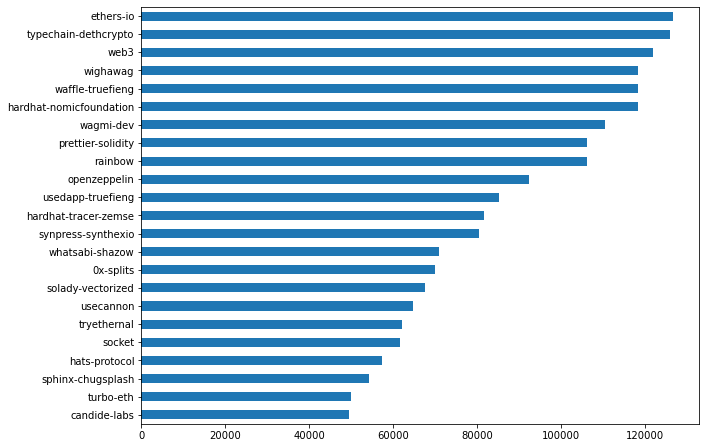

In [7]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_DESC, LIST_LINK, LIST_EVAL, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)